# Churn prediction

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Output directory for graphs
output_directory = 'figures/'
if (not os.path.isdir(output_directory)):
    os.mkdir(output_directory)

## Data loading

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [3]:
df.value_counts('Exited')

Exited
0    7963
1    2037
Name: count, dtype: int64

The dataset is imbalanced, with roughly 4 times as many customers that have stayed at the bank as customers that have left it. This is to be expected for a functioning bank. In this notebook, we will not do any data over/under-sampling to try to mitigate the effects of data imbalance. As a result, we can expect ensemble techniques (_e.g._, random forest) to perform better on this data.

## Data preparation (no feature engineering)

In [4]:
df_prep = df.copy()

# Label encode gender from Female/Male to 0/1
label_encoder = LabelEncoder()
df_prep['Gender'] = label_encoder.fit_transform(df_prep['Gender'])

# One-hot encode geography
df_prep = pd.get_dummies(df_prep, columns=['Geography'], drop_first=True)
df_prep

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,2,15647311,Hill,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,3,15619304,Onio,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,4,15701354,Boni,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,5,15737888,Mitchell,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,1,39,5,0.00,2,1,0,96270.64,0,False,False
9996,9997,15569892,Johnstone,516,1,35,10,57369.61,1,1,1,101699.77,0,False,False
9997,9998,15584532,Liu,709,0,36,7,0.00,1,0,1,42085.58,1,False,False
9998,9999,15682355,Sabbatini,772,1,42,3,75075.31,2,1,0,92888.52,1,True,False


In [5]:
# Select features for analysis
features = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance',
            'NumOfProducts', 'HasCrCard', 'IsActiveMember',
            'EstimatedSalary', 'Geography_Germany', 'Geography_Spain']

# Split data into training and testing sets
X = df_prep[features]
y = df_prep['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (our features have very different scales)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model training and assessment

### Random forest

In [6]:
# Build and train model
model_rand_forest = RandomForestClassifier(n_estimators=100, random_state=42)
model_rand_forest.fit(X_train, y_train)

# Make predictions
y_pred_rand_forest = model_rand_forest.predict(X_test)

# Evaluate model performance
conf_matrix_rand_forest = confusion_matrix(y_test, y_pred_rand_forest)
class_report_rand_forest = classification_report(y_test, y_pred_rand_forest)
accuracy_rand_forest = accuracy_score(y_test, y_pred_rand_forest)

print('Confusion matrix:')
print(conf_matrix_rand_forest)
print('Accuracy:')
print(accuracy_rand_forest)
print('Classification report:')
print(class_report_rand_forest)

Confusion matrix:
[[1550   57]
 [ 208  185]]
Accuracy:
0.8675
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000



### Logistic regression

In [8]:
# Build and train model
model_log_reg = LogisticRegression(random_state=42)
model_log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = model_log_reg.predict(X_test)

# Evaluate model performance
conf_matrix = confusion_matrix(y_test, y_pred_log_reg)
class_report = classification_report(y_test, y_pred_log_reg)
accuracy = accuracy_score(y_test, y_pred_log_reg)

print('Confusion matrix:')
print(conf_matrix)
print('Accuracy:')
print(accuracy)
print('Classification report:')
print(class_report)

Confusion matrix:
[[1543   64]
 [ 314   79]]
Accuracy:
0.811
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1607
           1       0.55      0.20      0.29       393

    accuracy                           0.81      2000
   macro avg       0.69      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



### Linear support vector machine (SVM)

In [9]:
# Build and train model
model_linear_svm = SVC(kernel='linear', random_state=42)
model_linear_svm.fit(X_train, y_train)

# Make predictions
y_pred_linear_svm = model_linear_svm.predict(X_test)

# Evaluate model performance
conf_matrix = confusion_matrix(y_test, y_pred_linear_svm)
class_report = classification_report(y_test, y_pred_linear_svm,
                                     zero_division=0)
accuracy = accuracy_score(y_test, y_pred_linear_svm)

print('Confusion matrix:')
print(conf_matrix)
print('Accuracy:')
print(accuracy)
print('Classification report:')
print(class_report)

Confusion matrix:
[[1607    0]
 [ 393    0]]
Accuracy:
0.8035
Classification report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1607
           1       0.00      0.00      0.00       393

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.45      2000
weighted avg       0.65      0.80      0.72      2000



Here, `zero_division` was set to 0 in `classification_report` to suppress a warning arising from the fact that the SVM does not predict any exiting customer. The above accuracy thus corresponds to the ratio of the number of remaining customers divided by the total number of customer: 1607/(1607 + 393) = 0.8035.

### Radial support vector machine

In [10]:
# Build and train model
model_radial_svm = SVC(kernel='rbf', random_state=42)
model_radial_svm.fit(X_train, y_train)

# Make predictions
y_pred_radial_svm = model_radial_svm.predict(X_test)

# Evaluate model performance
conf_matrix = confusion_matrix(y_test, y_pred_radial_svm)
class_report = classification_report(y_test, y_pred_radial_svm)
accuracy = accuracy_score(y_test, y_pred_radial_svm)

print('Confusion matrix:')
print(conf_matrix)
print('Accuracy:')
print(accuracy)
print('Classification report:')
print(class_report)

Confusion matrix:
[[1562   45]
 [ 243  150]]
Accuracy:
0.856
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1607
           1       0.77      0.38      0.51       393

    accuracy                           0.86      2000
   macro avg       0.82      0.68      0.71      2000
weighted avg       0.85      0.86      0.84      2000



### K-nearest neighbors

In [11]:
# Build and train model
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = model_knn.predict(X_test)

# Evaluate model performance
conf_matrix = confusion_matrix(y_test, y_pred_knn)
class_report = classification_report(y_test, y_pred_knn)
accuracy = accuracy_score(y_test, y_pred_knn)

print('Confusion matrix:')
print(conf_matrix)
print('Accuracy:')
print(accuracy)
print('Classification report:')
print(class_report)

Confusion matrix:
[[1514   93]
 [ 247  146]]
Accuracy:
0.83
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1607
           1       0.61      0.37      0.46       393

    accuracy                           0.83      2000
   macro avg       0.74      0.66      0.68      2000
weighted avg       0.81      0.83      0.81      2000



### Gradient-boosting classifier

In [12]:
# Build and train model
model_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
model_gb.fit(X_train, y_train)

# Make predictions
y_pred_gb = model_gb.predict(X_test)

# Evaluate model performance
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

print('Confusion matrix:')
print(conf_matrix_gb)
print('Accuracy:')
print(accuracy_gb)
print('Classification report:')
print(class_report_gb)

Confusion matrix:
[[1543   64]
 [ 201  192]]
Accuracy:
0.8675
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.49      0.59       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000



In [13]:
print('----- Initial random forest -----')
print('Confusion matrix:')
print(conf_matrix_rand_forest)
print('Accuracy:')
print(accuracy_rand_forest)
print('Classification report:')
print(class_report_rand_forest)

----- Initial random forest -----
Confusion matrix:
[[1550   57]
 [ 208  185]]
Accuracy:
0.8675
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000



The random-forest and gradient-boosting classifiers perform the best, with similar levels of accuracy, precision and recall.

### Feature importance

Let us plot feature importances for our two best classifiers.

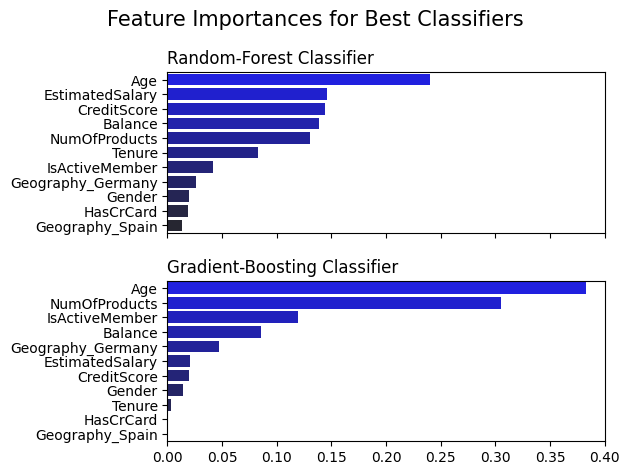

In [14]:
models = {'Random-Forest Classifier': model_rand_forest,
          'Gradient-Boosting Classifier': model_gb}

fig, ax = plt.subplots(2, 1)
for i, (model_name, model) in enumerate(models.items()):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [features[i] for i in indices]

    sns.barplot(x=importances[indices], y=range(X.shape[1]), hue=range(X.shape[1]),
                ax=ax[i], orient='h', palette='dark:b_r', legend=False)
    ax[i].set_yticks(range(X.shape[1]), names)
    ax[i].set_title(model_name, loc='left')
    ax[i].set_xlim([0, 0.4])
    if i == 0:
        ax[i].set_xticklabels('')
plt.suptitle('Feature Importances for Best Classifiers',
             y=0.98, fontsize=15)
plt.tight_layout(h_pad=1.5)
plt.savefig(os.path.join(output_directory, '2_1_feature_importance_best_classifiers.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- Feature importances differ between our two best classifiers.
- That being said, customer age is the most important feature for both classifiers.
    - Customer age was already identified as an important feature when assessing churn risks during the exploratory data analysis.
- Compared to the random-forest classifier, the gradient-boosting classifier gives more importance to fewer features.

## Feature engineering

### Data preparation

In [15]:
df_eng = df_prep.copy()

# Binary feature for balance
df_eng['ZeroBalance'] = (df_eng['Balance'] == 0)

# Age groups
# (One of this groups, 36-55 covers the majority of customers leaving the bank,
#  as seen during the exploratory data analysis)
df_eng['AgeGroup'] = pd.cut(df_eng['Age'],
                            bins=[18, 35, 55, 75, 95],
                            labels=['18-35', '36-55', '56-75', '76-95'])

df_eng = pd.get_dummies(df_eng, columns=['AgeGroup'], drop_first=True)

# Ratio of balance and salary
df_eng['RatioBalanceSalary'] = df_eng['Balance']/df_eng['EstimatedSalary']

# Number of products in active use
df_eng['ProductUsage'] = df_eng['NumOfProducts']*df_eng['IsActiveMember']

# Combined gender/geography features
df_eng['Male_Germany'] = df_eng['Gender']*df_eng['Geography_Germany']
df_eng['Male_Spain'] = df_eng['Gender']*df_eng['Geography_Spain']

df_eng

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,Geography_Germany,Geography_Spain,ZeroBalance,AgeGroup_36-55,AgeGroup_56-75,AgeGroup_76-95,RatioBalanceSalary,ProductUsage,Male_Germany,Male_Spain
0,1,15634602,Hargrave,619,0,42,2,0.00,1,1,...,False,False,True,True,False,False,0.000000,1,0,0
1,2,15647311,Hill,608,0,41,1,83807.86,1,0,...,False,True,False,True,False,False,0.744677,1,0,0
2,3,15619304,Onio,502,0,42,8,159660.80,3,1,...,False,False,False,True,False,False,1.401375,0,0,0
3,4,15701354,Boni,699,0,39,1,0.00,2,0,...,False,False,True,True,False,False,0.000000,0,0,0
4,5,15737888,Mitchell,850,0,43,2,125510.82,1,1,...,False,True,False,True,False,False,1.587055,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,1,39,5,0.00,2,1,...,False,False,True,True,False,False,0.000000,0,0,0
9996,9997,15569892,Johnstone,516,1,35,10,57369.61,1,1,...,False,False,False,False,False,False,0.564108,1,0,0
9997,9998,15584532,Liu,709,0,36,7,0.00,1,0,...,False,False,True,True,False,False,0.000000,1,0,0
9998,9999,15682355,Sabbatini,772,1,42,3,75075.31,2,1,...,True,False,False,True,False,False,0.808230,0,1,0


In [16]:
# Select features for analysis
features = (['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance',
             'NumOfProducts', 'HasCrCard', 'IsActiveMember',
             'EstimatedSalary', 'Geography_Germany', 'Geography_Spain']
            + ['ZeroBalance', 'RatioBalanceSalary', 'ProductUsage',
               'Male_Germany', 'Male_Spain']
            + [column for column in df_eng.columns if ('AgeGroup_' in column)]
            )

# Split data into training and testing sets
X = df_eng[features]
y = df_eng['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (our features have very different scales)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Random forest

In [17]:
# Build and train model
model_rand_forest_2 = RandomForestClassifier(n_estimators=100, random_state=42)
model_rand_forest_2.fit(X_train, y_train)

# Make predictions
y_pred_rand_forest_2 = model_rand_forest_2.predict(X_test)

# Evaluate model performance
conf_matrix = confusion_matrix(y_test, y_pred_rand_forest_2)
class_report = classification_report(y_test, y_pred_rand_forest_2)
accuracy = accuracy_score(y_test, y_pred_rand_forest_2)

print('Confusion matrix:')
print(conf_matrix)
print('Accuracy:')
print(accuracy)
print('Classification report:')
print(class_report)

Confusion matrix:
[[1549   58]
 [ 204  189]]
Accuracy:
0.869
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.77      0.48      0.59       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000



In [18]:
print('----- Initial random forest -----')
print('Confusion matrix:')
print(conf_matrix_rand_forest)
print('Accuracy:')
print(accuracy_rand_forest)
print('Classification report:')
print(class_report_rand_forest)

----- Initial random forest -----
Confusion matrix:
[[1550   57]
 [ 208  185]]
Accuracy:
0.8675
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000



### Gradient-boosting classifier

In [19]:
# Build and train model
model_gb_2 = GradientBoostingClassifier(n_estimators=100, random_state=42)
model_gb_2.fit(X_train, y_train)

# Make predictions
y_pred_gb_2 = model_gb_2.predict(X_test)

# Evaluate model performance
conf_matrix = confusion_matrix(y_test, y_pred_gb_2)
class_report = classification_report(y_test, y_pred_gb_2)
accuracy = accuracy_score(y_test, y_pred_gb_2)

print('Confusion matrix:')
print(conf_matrix)
print('Accuracy:')
print(accuracy)
print('Classification report:')
print(class_report)

Confusion matrix:
[[1544   63]
 [ 205  188]]
Accuracy:
0.866
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.48      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000



In [20]:
print('----- Initial gradient-boosting classifier -----')
print('Confusion matrix:')
print(conf_matrix_gb)
print('Accuracy:')
print(accuracy_gb)
print('Classification report:')
print(class_report_gb)

----- Initial gradient-boosting classifier -----
Confusion matrix:
[[1543   64]
 [ 201  192]]
Accuracy:
0.8675
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.49      0.59       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000



**Breakdown:**
- With the new features, the performance of the random-forest classifier improved very slightly.
- However, the performance of the gradient-boosting classifier worsened very slightly.

### Feature importance

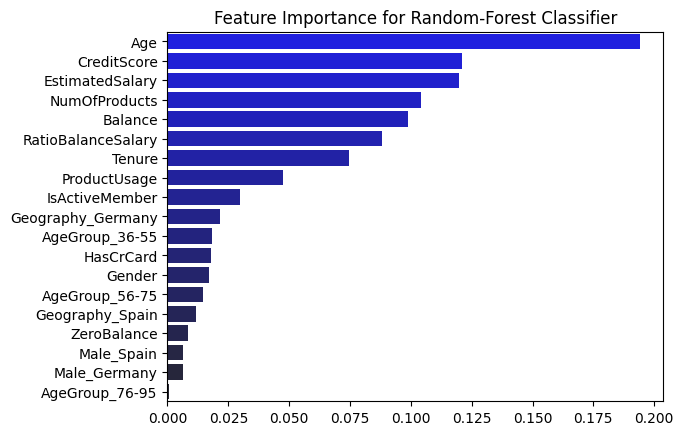

In [21]:
importances = model_rand_forest_2.feature_importances_
indices = np.argsort(importances)[::-1]
names = [features[i] for i in indices]

sns.barplot(x=importances[indices], y=range(X.shape[1]), hue=range(X.shape[1]),
            orient='h', palette='dark:b_r', legend=False)
plt.yticks(range(X.shape[1]), names)
plt.title('Feature Importance for Random-Forest Classifier')
plt.savefig(os.path.join(output_directory, '2_2_feature_importance_random_forest_post_engineering.png'),
            bbox_inches='tight', dpi=600)
plt.show()

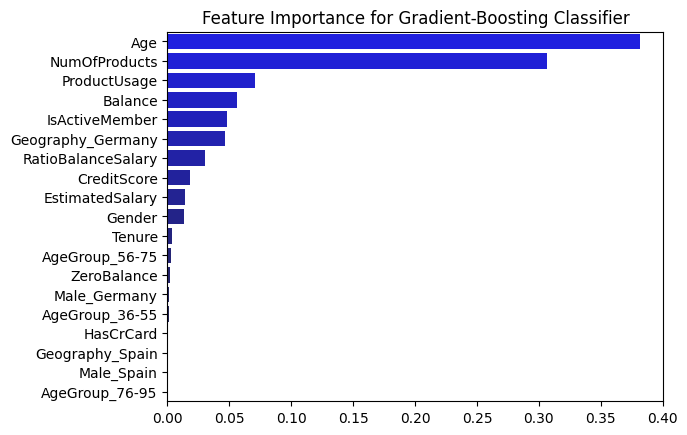

In [22]:
importances = model_gb_2.feature_importances_
indices = np.argsort(importances)[::-1]
names = [features[i] for i in indices]

sns.barplot(x=importances[indices], y=range(X.shape[1]), hue=range(X.shape[1]),
            orient='h', palette='dark:b_r', legend=False)
plt.yticks(range(X.shape[1]), names)
plt.title('Feature Importance for Gradient-Boosting Classifier')
plt.savefig(os.path.join(output_directory, '2_3_feature_importance_gradient_boosting_post_engineering.png'),
            bbox_inches='tight', dpi=600)
plt.show()

The aforementioned performance changes observed after feature engineering may be due to the fact that the random-forest classifier employs most of the features (including the new ones) to a certain extent, while the gradient-boosting classifier still focuses on its few top features.

## Hyperparameter tuning

Let us focus on the random-forest classifier with our new set of features, as it is faster than the gradient-boosting classifier to tune _via_ cross-validated grid search.

In [26]:
# Cross-validated grid search
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 4, 6],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

model_rand_forest_tuned = grid_search.best_estimator_

model_rand_forest_tuned

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

In [27]:
# Make predictions
y_pred = model_rand_forest_tuned.predict(X_test)

# Evaluate model performance
conf_matrix = confusion_matrix(y_test, y_pred_gb_2)
class_report = classification_report(y_test, y_pred_gb_2)
accuracy = accuracy_score(y_test, y_pred_gb_2)

print('Confusion matrix:')
print(conf_matrix)
print('Accuracy:')
print(accuracy)
print('Classification report:')
print(class_report)

Confusion matrix:
[[1544   63]
 [ 205  188]]
Accuracy:
0.866
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.75      0.48      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000



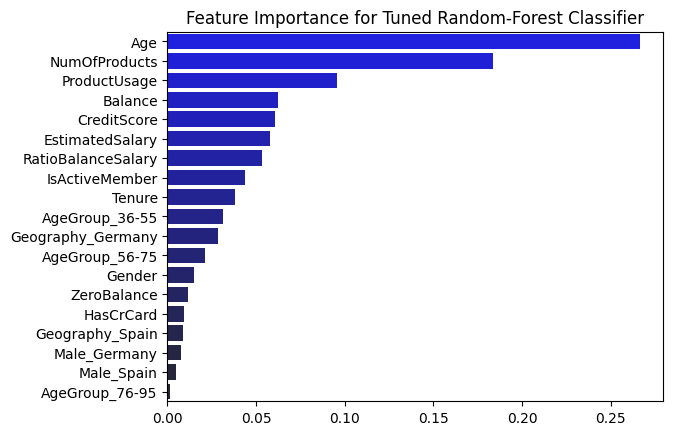

In [28]:
# Feature importance
importances = model_rand_forest_tuned.feature_importances_
indices = np.argsort(importances)[::-1]
names = [features[i] for i in indices]

sns.barplot(x=importances[indices], y=range(X.shape[1]), hue=range(X.shape[1]),
            orient='h', palette='dark:b_r', legend=False)
plt.yticks(range(X.shape[1]), names)
plt.title('Feature Importance for Tuned Random-Forest Classifier')
plt.savefig(os.path.join(output_directory, '2_4_feature_importance_tuned_random_forest_post_engineering.png'),
            bbox_inches='tight', dpi=600)
plt.show()

**Breakdown:**
- The top 4 features for the tuned random-forest classifier are now identical to those found previously for the gradient-boosting classifier.
- Like the previous gradient-boosting classifier, the tuned random-forest classifier also gives more importance to its top features. 